In [1]:
import numpy as np
import numpy.random as npr

import tensorflow as tf

from tqdm import trange

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

tf.random.set_seed(1234)
npr.seed(1234)

In [2]:
class Dense(tf.Module):
    def __init__(self, input_dim, output_dim, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([input_dim, output_dim]), name='weights_%s'%name)
        self.b = tf.Variable(tf.zeros([output_dim]), name='biases_%s'%name)
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b
    
class MLP(tf.Module):
    def __init__(self, input_size, output_size, hidden_sizes, name=None):
        super().__init__(name=name)
        self.layers = []
        with self.name_scope:
            for size in hidden_sizes:
                self.layers.append(Dense(input_dim=input_size, output_dim=size, name='i'))
                self.layers.append(tf.nn.tanh)
                input_size = size
            self.layers.append(Dense(input_dim=input_size, output_dim=output_size, name='output'))
            
    @tf.function
    @tf.Module.with_name_scope
    def __call__(self, x):
        z = x
        for layer in self.layers:
            z = layer(z)
        return z

In [3]:
class HeatEq1D():
    def __init__(self, X_dat, y_dat, X_res, f_tf, layers):
        # scaling factors
        self.Xmean, self.Xstd = X_res.mean(0), X_res.std(0)
        
        # normalize data
        X_dat = (X_dat-self.Xmean) / self.Xstd
        X_res = (X_res-self.Xmean) / self.Xstd
        
        # weights that are 
        self.alpha = tf.constant(1.0)
        self.beta  = tf.constant(1.0)

        # store the normalized training data
        self.X_d = X_dat.astype(np.float32)
        self.y_d = y_dat.astype(np.float32)
        self.X_r = X_res.astype(np.float32)
        self.y_r = np.zeros((X_res.shape[0], 1), dtype=np.float32)
        
        self.f = f_tf
        self.layers = layers

        # set up network initialization and evaluation functions
        self.Tnet = MLP(input_size=layers[0], output_size=layers[-1], hidden_sizes=layers[1:-1], name='Tnet')
        
        self.variables = self.Tnet.trainable_variables
        
        print('Trainable parameters:')
        print('===================================')
        for var in self.variables:
            print(var.name, ', shape:', list(var.shape))
        print('\n')

        # use tf optimizers to set optimizer initialization and learning rate scheduler
        initial_lr = 1e-3
        self.lr_scheduler = tf.optimizers.schedules.ExponentialDecay(initial_lr,
                                                                     decay_steps=200,
                                                                     decay_rate=0.95,
                                                                     staircase=True)
        self.opt = tf.optimizers.Adam(lr=initial_lr)
        
        # define mean squared error loss
        self.MSE = tf.losses.MeanSquaredError()

        # logger to monitor the loss function
        self.loss_dat_log = []
        self.loss_res_log = []

    # forward pass for T
    def forward_T(self, x):
        return self.Tnet(x)
    
    # forward pass for equation residual
    def forward_R(self, x):
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            with tf.GradientTape() as tape1:
                tape1.watch(x)
                T = self.forward_T(x)
            T_x = tape1.gradient(T, x) / self.Xstd
        T_xx = tape2.gradient(T_x, x) / self.Xstd
        
        residual = T_xx - self.f(x*self.Xstd + self.Xmean)
        return residual
    
    @tf.function
    def loss(self, batch):
        X_d, y_d, X_r, y_r = batch
        loss_d = self.MSE(y_d, self.forward_T(X_d))
        loss_r = self.MSE(y_r, self.forward_R(X_r))
        return loss_d, loss_r

    def data_stream(self, n, num_batches, batch_size):
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(n)
            for i in range(num_batches):
                batch_idx = perm[i*batch_size:(i+1)*batch_size]
                yield self.X_d, self.y_d, self.X_r[batch_idx], self.y_r[batch_idx]
        
    def train(self, num_epochs=100, batch_size=64):   
        n = self.X_r.shape[0]
        num_complete_batches, leftover = divmod(n, batch_size)
        num_batches = num_complete_batches + bool(leftover)
        assert n > num_batches
        batches = self.data_stream(n, num_batches, batch_size)
        
        pbar = trange(num_epochs)
        for epoch in pbar:
            loss_dat = 0.
            loss_res = 0.
            loss_tot = 0.
            for _ in range(num_batches):
                batch = next(batches)
                with tf.GradientTape(persistent=True) as tape:
                    loss_d, loss_r = self.loss(batch)
                    loss_t = self.alpha*loss_d + self.beta*loss_r
                grads = tape.gradient(loss_t, self.variables)
                self.opt.apply_gradients(zip(grads, self.variables))
                loss_dat += loss_d
                loss_res += loss_r
                loss_tot += loss_t
            pbar.set_postfix({'Total Loss': loss_tot.numpy()/num_batches})
            self.loss_dat_log.append(loss_dat/num_batches)
            self.loss_res_log.append(loss_res/num_batches)
            self.lr_scheduler(epoch)
    
    # evaluate predictions at test points
    def predict_T(self, X_star):
        X_star = (X_star-self.Xmean) / self.Xstd
        y_pred = self.forward_T(X_star.astype(np.float32))
        return y_pred
    
    def predict_R(self, X_star):
        X_star = (X_star-self.Xmean) / self.Xstd
        r_pred = self.forward_R(X_star.astype(np.float32))
        return r_pred

In [4]:
# define forcing term
def f(x):
    return -np.pi**2 * np.sin(np.pi*x)

# define forcing term (in Tensorflow semantics)
def f_tf(x):
    return -np.pi**2 * tf.sin(np.pi*x)

# define exact solution (for validation purposes)    
def u(x):
    return np.sin(np.pi*x)

# Number of training data
N_u = 2                        # Boundary condition data on u(x)
N_r = 256                      # Number of collocation points for minimizing the PDE residual
lb  = np.array([-1.0])         # Left boundary of the domain
ub  = np.array([1.0])          # Right boundary of the domain

# Generate training data
x_u = np.linspace(lb, ub, N_u)     # Location of boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)
y_u = u(x_u)                       # Solution at boundary points (dimension N_u x 1)

# Test data for validating the model predictions
n_star = 1024
x_star = np.linspace(lb, ub, n_star)
u_star = u(x_star)
f_star = f(x_star)

In [5]:
# fully-connected neural net architecture (dimensions of each layer)
layers = [1, 64, 1]

# define PINN model
model = HeatEq1D(x_u, y_u, x_r, f_tf, layers)

Trainable parameters:
Tnet/biases_i:0 , shape: [64]
Tnet/weights_i:0 , shape: [1, 64]
Tnet/biases_output:0 , shape: [1]
Tnet/weights_output:0 , shape: [64, 1]




In [6]:
model.train(num_epochs=1000, batch_size=64)

100%|██████████| 1000/1000 [01:51<00:00,  8.97it/s, Total Loss=0.133]


In [7]:
# Compute prediction using the trained model
x_ = x_star.reshape(-1, 64)
T_pred = np.vstack([model.predict_T(x_[i:i+1].T) for i in range(x_.shape[0])])
error_u = np.linalg.norm(u_star-T_pred, 2)/np.linalg.norm(u_star, 2)
print('Relative L2 error_T: %e' % (error_u))

Relative L2 error_T: 1.663445e-02


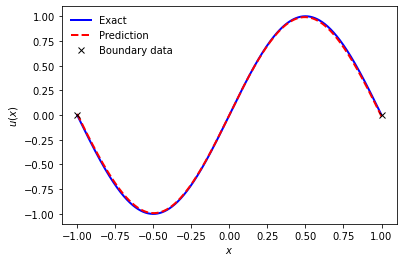

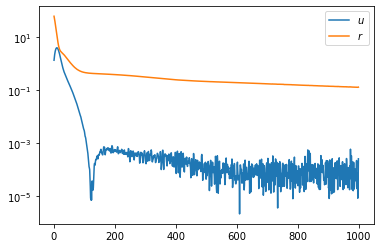

In [8]:
# Plotting
plt.figure(1)
plt.plot(x_star, u_star, 'b-', linewidth = 2, label = "Exact")
plt.plot(x_star, T_pred, 'r--', linewidth = 2, label = "Prediction")
plt.plot(x_u, y_u, 'kx', linewidth = 2, label = "Boundary data")
plt.legend(frameon=False, loc='upper left')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')


fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
ax.plot(model.loss_dat_log, label = '$u$')
ax.plot(model.loss_res_log, label = '$r$')
ax.set_yscale('log')
plt.legend()